In [1]:
# Utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time 
import random

# Neural Nets
import tensorflow as tf
import tensorflow_probability as tfp
from keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

# Config 
import sys
import os
import pickle
from dotenv import load_dotenv
import warnings

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Data
from mkt_data_ETL.data_load_and_transform import get_data, get_top_mkt_cap_stocks

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def load_metric_from_all_datasets(metric_name: str) -> dict:
    """
    Carrega uma métrica específica dos arquivos de métricas de treinamento D1 a D4.

    Args:
        metric_name (str): Nome da métrica a ser carregada.

    Returns:
        dict: Dicionário com as métricas carregadas, chaves sendo 'D1', 'D2', 'D3', 'D4'.
    """
    metrics_dict = {}
    for i in range(1, 4):
        file_path = os.path.join(os.environ['SAVE_DIR'], f'training_metrics_D{i}.pkl')
        with open(file_path, 'rb') as f:
            metrics = pickle.load(f)
            if metric_name not in metrics:
                raise KeyError(f"Métrica '{metric_name}' não encontrada em training_metrics_D{i}.pkl")
            metrics_dict[f'D{i}'] = metrics[metric_name]
    return metrics_dict

In [10]:
loss_per_epoch = load_metric_from_all_datasets('avg_epoch_loss_vect')
adaptative_lambda_1 = load_metric_from_all_datasets('lambda_1_vect')
adaptative_lambda_2 = load_metric_from_all_datasets('lambda_2_vect')
# adaptative_lambda_3 = load_metric_from_all_datasets('lambda_3_vect')

drift  = load_metric_from_all_datasets('drift_per_batch_vect')



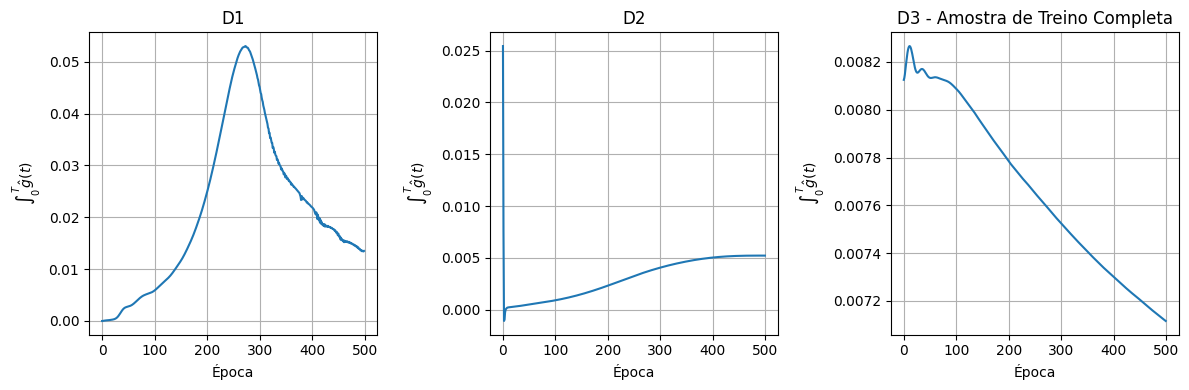

In [11]:
# Gerar imagem com 4 gráficos (1 por dataset)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()

for i, key in enumerate(['D1', 'D2', 'D3']):
    axs[i].plot(drift[key])
    if key == 'D3':
        key = 'D3 - Amostra de Treino Completa'
    axs[i].set_title(f'{key}')
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel(r'$\int_{0}^{T} \hat{g}(t)$')
    axs[i].grid(True)


plt.tight_layout()
plt.show()


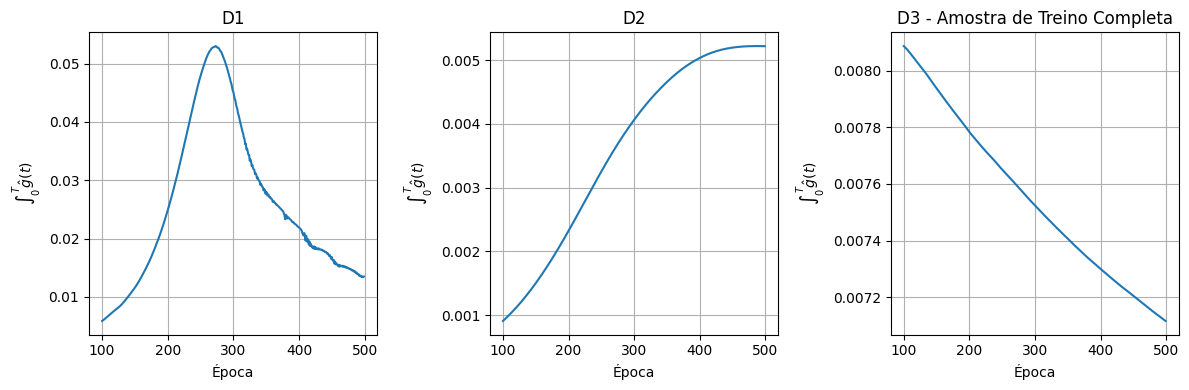

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()

for i, key in enumerate(['D1', 'D2', 'D3']):
    cut = 100
    if key == 'D3':
        cut = 100

    y_vals = drift[key][cut:]
    x_vals = list(range(cut, cut + len(y_vals)))

    axs[i].plot(x_vals, y_vals)

    title_key = 'D3 - Amostra de Treino Completa' if key == 'D3' else key
    axs[i].set_title(f'{title_key}')
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel(r'$\int_{0}^{T} \hat{g}(t)$')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


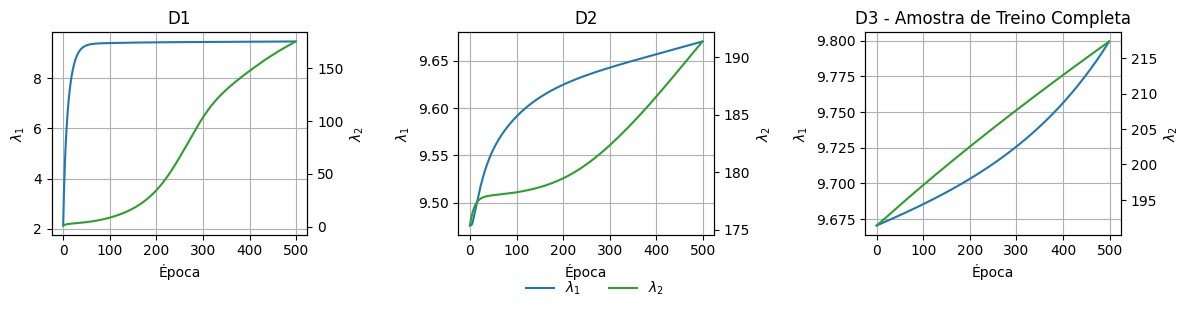

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs = axs.flatten()

for i, key in enumerate(['D1', 'D2', 'D3']):
    ax1 = axs[i]
    ax2 = ax1.twinx()  # eixo Y da direita para λ3

    # λ1 lado esquerdo
    ln1 = ax1.plot(adaptative_lambda_1[key], label=r'$\lambda_1$', color='tab:blue')
    
    # λ2 no eixo direito
    ln3 = ax2.plot(adaptative_lambda_2[key], label=r'$\lambda_2$', color='tab:green')

    title_key = 'D3 - Amostra de Treino Completa' if key == 'D3' else key
    ax1.set_title(f'{title_key}')
    ax1.set_xlabel('Época')

    # rótulos dos eixos Y conforme pedido
    ax1.set_ylabel(r'$\lambda_1$')
    ax2.set_ylabel(r'$\lambda_2$')

    ax1.grid(True)
    
# legenda única (proxies) centralizada embaixo
handles = [
    Line2D([0], [0], color='tab:blue', label=r'$\lambda_1$'),
    Line2D([0], [0], color='tab:green', linestyle='-', label=r'$\lambda_2$'),
]
fig.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

# reserva espaço para a legenda inferior
plt.tight_layout()
plt.show()
